# correlation power analysis

The basic concept of the attack is that, 
1. we take a real power trace
2. a hypothetical trace (depending on the model we choose),
3. and correlate this hypothetical model with the real one for all possible key guesses and choose the one with the highest correlation

### Importing the traces

In [1]:
file = 'traces_for_assignmnets/data1.pkl'

In [2]:
import pickle
import chipwhisperer.common.utils.util as cw

class RedirectUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == "chipwhisperer.common.utils.util" and name == "bytearray":
            return cw.CWByteArray
        return super().find_class(module, name)

with open(file, 'rb') as f:
    data = RedirectUnpickler(f).load()
trace_array = data['trace_array']
textin_array = data['textin_array']
textout_array = data['textout_array']
key_array = data['key_array']

print('plaintext:',textin_array[0])
print('key:',key_array[0])
print('ciphertext:',textout_array[0])

plaintext: CWbytearray(b'f1 6d 85 ba a5 33 8e 79 44 99 db 95 7b a7 05 fa')
key: CWbytearray(b'99 b7 4f 8d 73 93 35 40 07 09 a6 71 1e 6e 1f 87')
ciphertext: CWbytearray(b'32 76 bd 33 8d da ad af 0c fe dd b0 bc 2d 57 86')


The imported traces, looks like these
1. trace_array = [[text1_point1, text1_point2, .... , text1_point5000],.....,[text50_point1, text50_point2, .... , text50_point5000]]
2. textin_array = [plaintext1, plaintext2,.......plaintext50]
3. textout_array = [ciphertext1, ciphertext2,....., ciphertext50]
4. key_array = [key, key, key... , key]

we can see the plot of power trace here

<function matplotlib.pyplot.show(close=None, block=None)>

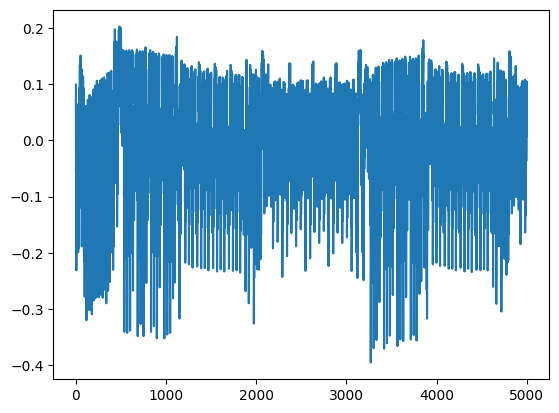

In [3]:
import matplotlib.pyplot as plt
plt.plot(trace_array[0])
plt.show

Now that we have the real traces, we will look into generating simulated trace using hamming weight power model

In [4]:
sbox = [
    # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f 
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76, # 0
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0, # 1
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15, # 2
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75, # 3
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84, # 4
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf, # 5
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8, # 6
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2, # 7
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73, # 8
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb, # 9
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79, # a
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08, # b
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a, # c
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e, # d
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf, # e
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16  # f
]

def aes_internal(inputdata, key):
    return sbox[inputdata ^ key]

HW = [bin(n).count("1") for n in range(0, 256)]

### Pearson correlation coefficient

we'll be testing how good our guess is by using a measurement called the Pearson correlation coefficient, which measures the linear correlation between two datasets.

The actual algorithm is as follows for datasets $X$ and $Y$ of length $N$, with means of $\bar{X}$ and $\bar{Y}$, respectively:

$$r = \frac{cov(X, Y)}{\sigma_X \sigma_Y}$$

$cov(X, Y)$ is the covariance of `X` and `Y` and can be calculated as follows:

$$cov(X, Y) = \sum_{n=1}^{N}[(Y_n - \bar{Y})(X_n - \bar{X})]$$

$\sigma_X$ and $\sigma_Y$ are the standard deviation of the two datasets. This value can be calculated with the following equation:

$$\sigma_X = \sqrt{\sum_{n=1}^{N}(X_n - \bar{X})^2}$$

In [5]:
import numpy as np
def mean(X):
    return np.sum(X, axis=0)/len(X)

def std_dev(X, X_bar):
    return np.sqrt(np.sum((X-X_bar)**2, axis=0))

def cov(X, X_bar, Y, Y_bar):
    return np.sum((X-X_bar)*(Y-Y_bar), axis=0)

we calculate hamming weights for a single key byte for all 256 subkeys

In [6]:
maxcpa = [0] * 256
t_bar = mean(trace_array) 
sigma_t = std_dev(trace_array, t_bar)

for kguess in range(0, 256):
    hws = np.array([[HW[aes_internal(textin[0],kguess)] for textin in textin_array]]).transpose()
    hws_bar = mean(hws)
    sigma_hws = std_dev(hws, hws_bar)
    correlation = cov(trace_array, t_bar, hws, hws_bar)
    cpaoutput = correlation/(sigma_t*sigma_hws)
    # plt.plot(cpaoutput)
    # plt.show
    maxcpa[kguess] = max(abs(cpaoutput))
    

guess = np.argmax(maxcpa)
guess_corr = max(maxcpa)
# index = np.argmax(maxcpa)
# print(index)
print("Key guess: ", hex(guess))
print("Correlation: ", guess_corr)

Key guess:  0x99
Correlation:  0.8921445427123303


In [7]:
maxcpa = [0] * 256
t_bar = mean(trace_array) 
sigma_t = std_dev(trace_array, t_bar)
key = []
for i in range(16):
    for kguess in range(0, 256):
        hws = np.array([[HW[aes_internal(textin[i],kguess)] for textin in textin_array]]).transpose()
        hws_bar = mean(hws)
        sigma_hws = std_dev(hws, hws_bar)
        correlation = cov(trace_array, t_bar, hws, hws_bar)
        cpaoutput = correlation/(sigma_t*sigma_hws)
        maxcpa[kguess] = max(abs(cpaoutput))
    guess = np.argmax(maxcpa)
    key.append(guess)
    guess_corr = max(maxcpa)
key = cw.CWByteArray(key)
print("Key guess: ", key)
print("actual key:", key_array[0])

Key guess:  CWbytearray(b'99 b7 4f 8d 73 93 35 40 07 09 a6 71 1e 6e 1f 87')
actual key: CWbytearray(b'99 b7 4f 8d 73 93 35 40 07 09 a6 71 1e 6e 1f 87')


-------

Using ciphertexts

In [8]:
InvSbox = [
    0x52, 0x09, 0x6a, 0xd5, 0x30, 0x36, 0xa5, 0x38, 0xbf, 0x40, 0xa3, 0x9e, 0x81, 0xf3, 0xd7, 0xfb,
    0x7c, 0xe3, 0x39, 0x82, 0x9b, 0x2f, 0xff, 0x87, 0x34, 0x8e, 0x43, 0x44, 0xc4, 0xde, 0xe9, 0xcb,
    0x54, 0x7b, 0x94, 0x32, 0xa6, 0xc2, 0x23, 0x3d, 0xee, 0x4c, 0x95, 0x0b, 0x42, 0xfa, 0xc3, 0x4e,
    0x08, 0x2e, 0xa1, 0x66, 0x28, 0xd9, 0x24, 0xb2, 0x76, 0x5b, 0xa2, 0x49, 0x6d, 0x8b, 0xd1, 0x25,
    0x72, 0xf8, 0xf6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xd4, 0xa4, 0x5c, 0xcc, 0x5d, 0x65, 0xb6, 0x92,
    0x6c, 0x70, 0x48, 0x50, 0xfd, 0xed, 0xb9, 0xda, 0x5e, 0x15, 0x46, 0x57, 0xa7, 0x8d, 0x9d, 0x84,
    0x90, 0xd8, 0xab, 0x00, 0x8c, 0xbc, 0xd3, 0x0a, 0xf7, 0xe4, 0x58, 0x05, 0xb8, 0xb3, 0x45, 0x06,
    0xd0, 0x2c, 0x1e, 0x8f, 0xca, 0x3f, 0x0f, 0x02, 0xc1, 0xaf, 0xbd, 0x03, 0x01, 0x13, 0x8a, 0x6b,
    0x3a, 0x91, 0x11, 0x41, 0x4f, 0x67, 0xdc, 0xea, 0x97, 0xf2, 0xcf, 0xce, 0xf0, 0xb4, 0xe6, 0x73,
    0x96, 0xac, 0x74, 0x22, 0xe7, 0xad, 0x35, 0x85, 0xe2, 0xf9, 0x37, 0xe8, 0x1c, 0x75, 0xdf, 0x6e,
    0x47, 0xf1, 0x1a, 0x71, 0x1d, 0x29, 0xc5, 0x89, 0x6f, 0xb7, 0x62, 0x0e, 0xaa, 0x18, 0xbe, 0x1b,
    0xfc, 0x56, 0x3e, 0x4b, 0xc6, 0xd2, 0x79, 0x20, 0x9a, 0xdb, 0xc0, 0xfe, 0x78, 0xcd, 0x5a, 0xf4,
    0x1f, 0xdd, 0xa8, 0x33, 0x88, 0x07, 0xc7, 0x31, 0xb1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xec, 0x5f,
    0x60, 0x51, 0x7f, 0xa9, 0x19, 0xb5, 0x4a, 0x0d, 0x2d, 0xe5, 0x7a, 0x9f, 0x93, 0xc9, 0x9c, 0xef,
    0xa0, 0xe0, 0x3b, 0x4d, 0xae, 0x2a, 0xf5, 0xb0, 0xc8, 0xeb, 0xbb, 0x3c, 0x83, 0x53, 0x99, 0x61,
    0x17, 0x2b, 0x04, 0x7e, 0xba, 0x77, 0xd6, 0x26, 0xe1, 0x69, 0x14, 0x63, 0x55, 0x21, 0x0c, 0x7d,
]



def aes_external(inputdata, key):
    return InvSbox[inputdata ^ key]

### Using ciphertext and Hamming weight model

In [9]:
t_bar = mean(trace_array) 
sigma_t = std_dev(trace_array, t_bar)
maxcpa = [0] * 256
for kguess in range(0, 256):
    hws = np.array([[HW[aes_external(textout[0],kguess)] for textout in textout_array]]).transpose()
    hws_bar = mean(hws)
    sigma_hws = std_dev(hws, hws_bar)
    correlation = cov(hws, hws_bar, trace_array, t_bar)
    cpaoutput = correlation/(sigma_t*sigma_hws)
    maxcpa[kguess] = max(abs(cpaoutput))
    
guess = np.argmax(maxcpa)
guess_corr = max(maxcpa)   
# index = np.argmax(maxcpa)
# print(index)
print("Key guess: ", hex(guess))
print("Correlation: ", guess_corr)

Key guess:  0x36
Correlation:  0.641817396176118


In [12]:
t_bar = mean(trace_array) 
sigma_t = std_dev(trace_array, t_bar)
key = []
for i in range(16):
    maxcpa = [0] * 256
    for kguess in range(0, 256):
        hws = np.array([[HW[aes_external(textout[i],kguess)] for textout in textout_array]]).transpose()
        hws_bar = mean(hws)
        sigma_hws = std_dev(hws, hws_bar)
        correlation = cov(trace_array, t_bar, hws, hws_bar)
        cpaoutput = correlation/(sigma_t*sigma_hws)
        maxcpa[kguess] = max(abs(cpaoutput))
    
    guess = np.argmax(maxcpa)
    key.append(guess)
    guess_corr = max(maxcpa)
key = cw.CWByteArray(key)
print("Key guess: ", key)

Key guess:  CWbytearray(b'36 0d ff ac f0 d6 6d fa 43 33 b4 f2 c7 af 68 bc')


### Using Hamming distance model (DM)

In [10]:
t_bar = mean(trace_array) 
sigma_t = std_dev(trace_array, t_bar)
key = []
for i in range(16):
    maxcpa = [0] * 256
    for kguess in range(0, 256):
        hws = np.array([[HW[aes_external(textout[i],kguess) ^ textout[i]] for textout in textout_array]]).transpose()
        hws_bar = mean(hws)
        sigma_hws = std_dev(hws, hws_bar)
        correlation = cov(trace_array, t_bar, hws, hws_bar)
        cpaoutput = correlation/(sigma_t*sigma_hws)
        maxcpa[kguess] = max(abs(cpaoutput))
    
    guess = np.argmax(maxcpa)
    key.append(guess)
    guess_corr = max(maxcpa)
key = cw.CWByteArray(key)
print("Key guess: ", key)

Key guess:  CWbytearray(b'95 07 a1 73 e2 d6 4c 79 c8 77 d9 b5 ad 49 eb a1')


## summary


1. plaintext   :f1 6d 85 ba a5 33 8e 79 44 99 db 95 7b a7 05 fa
2. ciphertext  :32 76 bd 33 8d da ad af 0c fe dd b0 bc 2d 57 86
3. key         :99 b7 4f 8d 73 93 35 40 07 09 a6 71 1e 6e 1f 87
4. subkey10    :77 3a 4d 9f 6c 38 cc d3 d6 2c 8d 73 43 be c9 a5


key guess after CPA using
1. plaintext and Hamming weight model        : 99 b7 4f 8d 73 93 35 40 07 09 a6 71 1e 6e 1f 87  ✅(correct guess i.e. matching with actual key)
2. ciphertext and Hamming weight model       : 36 0d ff ac f0 d6 6d fa 43 33 b4 f2 c7 af 68 bc  ❌ (not matching with subkey10)
3. ciphertext and Hamming Distance model (DM): 95 07 a1 73 e2 d6 4c 79 c8 77 d9 b5 ad 49 eb a1  ❌(also not matching with subkey10)